# Neural Processes on discontinous data

## Question:
- Since q_target (based on the embedding of all x,y pairs) - not q_context - is used to describe the distribution of z in the forward pass during training, doesn't this hurt the uncertainty estimation performance? We are using a complete embedding for estimation, not just a partial one.

## ToDos
- Visualise co-variance function
- Add observation noise (fixed observation noise in paper)
- Monitor the balancing of the NLL term and kl term in  the loss function.

# Notes
- Uncertainty is captured both by the **stochasticity in z (latent space)** but also by the **probabilistic prediction in the output layer**.
- We optimise over mini-batches of tasks.
- Known underfitting problem of NPs (addressed by ANPs).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Visualize SineDiscontionous Data

$$ \text{for } x < bp: \\
 f(x) = a * sin(x - b)
$$

$$ \text{for } x \geq bp: \\
 f(x) = a * sin(x - b) + c
$$

$$ \text{with } \\
a\text{: amplitude scalar sampled uniformly from }(0.5, 1.)\\
b\text{: horizontal shift sampled uniformly from }(-0.5, 0.5)\\
c\text{: vertical shift sampled uniformly from }(0, 1)\\
bp\text{: breakpoint fixed to }(0).
$$

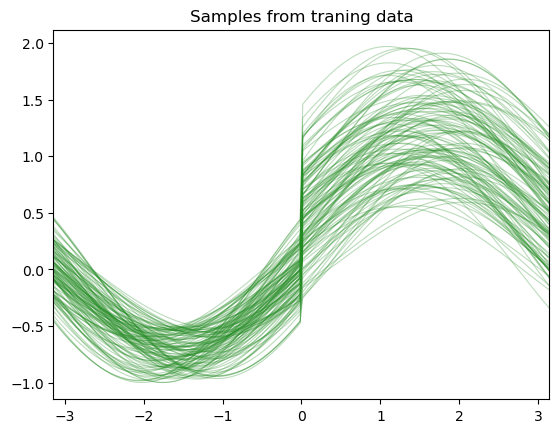

In [4]:
from math import pi
from datasets import SineDiscontData

# num_samples: number of different draws
# num_points: x spacing
dataset = SineDiscontData(num_samples = 4000, num_points = 200)

# Visualize all data samples
for i in range(127):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8')
    plt.title("Samples from traning data")
    plt.xlim(-pi, pi)

### Build Neural Process

In [5]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1

r_dim = 64  # Dimension of representation of context points
z_dim = 64  # Dimension of sampled latent variable
h_dim = 32  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

print(f"Number of parameters in model: {sum(p.numel() for p in neuralprocess.parameters())}")

Number of parameters in model: 20034


### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

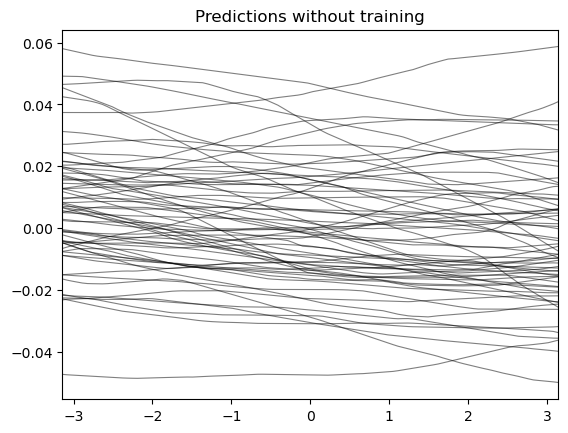

In [6]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    # Randomly sample/initialise z
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'black', alpha = 0.5, linewidth = '.8')
    plt.title("Predictions without training")
    plt.xlim(-pi, pi)

### Train Neural Process

In [8]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 8 # increase
num_context_min = 3
num_context_max = 6
num_target = 4 # extra targets

# 4000 samples, 8 samples per batch, thus 500 batches (iterations per epoch)
# DataLoader dimensionality is determined by n_samples % batch_size = n_batches
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr = 3e-4) # 0.0003
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range = (num_context_min, num_context_max),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 250) # is a divisor of n_batches

# Training mode
neuralprocess.training = True
np_trainer.train(data_loader, epochs = 50)

iteration 250, loss 4.785
iteration 500, loss 1.129
Epoch: 0, average loss: 2.148
iteration 750, loss 1.717
iteration 1000, loss -1.444
Epoch: 1, average loss: 0.113
iteration 1250, loss 0.701
iteration 1500, loss -2.022
Epoch: 2, average loss: -0.508
iteration 1750, loss 0.107
iteration 2000, loss -3.711
Epoch: 3, average loss: -1.094
iteration 2250, loss -2.093
iteration 2500, loss -0.208
Epoch: 4, average loss: -1.242
iteration 2750, loss -2.061
iteration 3000, loss 0.368
Epoch: 5, average loss: -1.471
iteration 3250, loss -0.754
iteration 3500, loss -2.304
Epoch: 6, average loss: -1.579
iteration 3750, loss -0.568
iteration 4000, loss -2.301
Epoch: 7, average loss: -1.666
iteration 4250, loss -2.743
iteration 4500, loss 0.526
Epoch: 8, average loss: -1.958
iteration 4750, loss -1.385
iteration 5000, loss -3.442
Epoch: 9, average loss: -2.001
iteration 5250, loss -4.422
iteration 5500, loss -0.984
Epoch: 10, average loss: -2.197
iteration 5750, loss -2.650
iteration 6000, loss -3.11

Text(0, 0.5, 'loss')

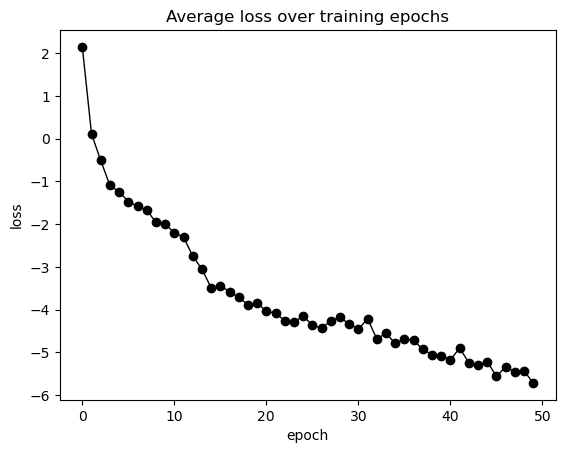

In [9]:
# Plot loss to assure convergence
plt.plot(list(range(0, len(np_trainer.epoch_loss_history))), np_trainer.epoch_loss_history, c = 'black', marker = 'o', linewidth = '1.')
plt.title("Average loss over training epochs")
plt.xlabel("epoch")
plt.ylabel("loss")

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

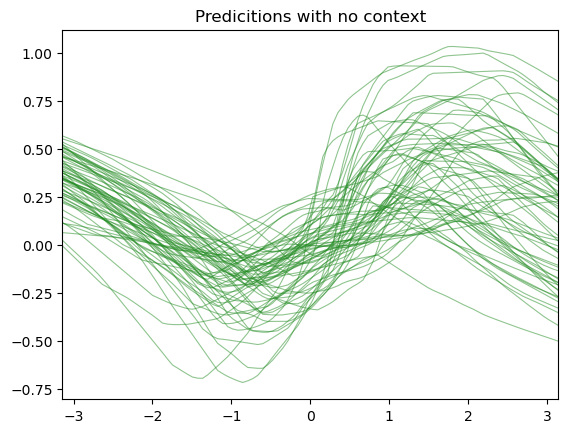

In [10]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'forestgreen', alpha = 0.5, linewidth = "0.8")
    plt.xlim(-pi, pi)
    plt.title("Predicitions with no context")

### Visualize samples from posterior

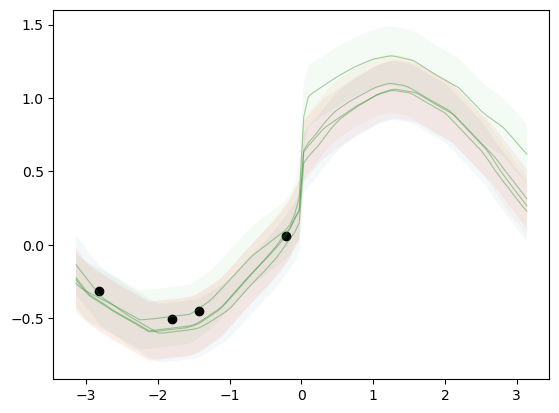

In [44]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break


# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

# showing 8
for i in range(4):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

- currently still underfitting a little bit to the context points

## Experiment 2

Change parameters

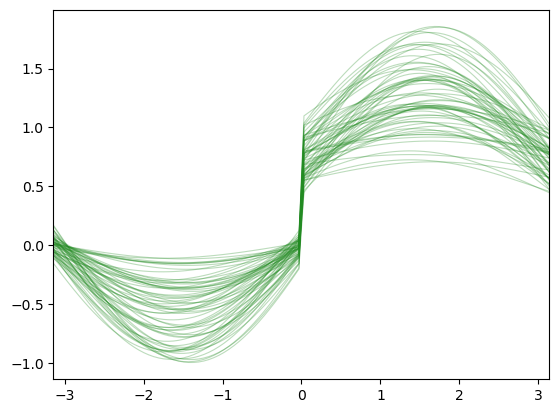

In [15]:
dataset2 = SineDiscontData(num_samples = 4000, amplitude_range = (0.1, 1.), 
                          horizontal_shift_range = (-.2, .2), 
                          vertical_shift_range = (0.5, 1))

# Visualize data samples
for i in range(64):
    x, y = dataset2[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8' )
    plt.xlim(-pi, pi)

In [16]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 128  # Dimension of representation of context points
z_dim = 128  # Dimension of sampled latent variable
h_dim = 64  # Dimension of hidden layers in encoder and decoder

neuralprocess2 = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [18]:
batch_size = 8
num_context = 4
num_target = 4 # extra targets

data_loader2 = DataLoader(dataset2, batch_size = batch_size, shuffle = True)
optimizer2 = torch.optim.Adam(neuralprocess2.parameters(), lr = 3e-4)
np_trainer2 = NeuralProcessTrainer(device, neuralprocess2, optimizer2,
                                  num_context_range = (num_context, num_context),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 200)

# Trainind mode
neuralprocess2.training = True
np_trainer2.train(data_loader2, epochs = 90)
# Originally it was 30

iteration 200, loss -4.306
iteration 400, loss -6.123
Epoch: 0, average loss: -5.018
iteration 600, loss -7.421
iteration 800, loss -4.423
iteration 1000, loss -7.071
Epoch: 1, average loss: -5.109
iteration 1200, loss -4.962
iteration 1400, loss -5.901
Epoch: 2, average loss: -5.387
iteration 1600, loss -7.541
iteration 1800, loss -6.979
iteration 2000, loss -7.133
Epoch: 3, average loss: -5.604
iteration 2200, loss -7.657
iteration 2400, loss -4.606
Epoch: 4, average loss: -5.712
iteration 2600, loss -6.271
iteration 2800, loss -5.960
iteration 3000, loss -6.405
Epoch: 5, average loss: -5.822
iteration 3200, loss -7.849
iteration 3400, loss -6.811
Epoch: 6, average loss: -5.673
iteration 3600, loss -7.585
iteration 3800, loss -5.904
iteration 4000, loss -1.190
Epoch: 7, average loss: -6.091
iteration 4200, loss -4.845
iteration 4400, loss -5.912
Epoch: 8, average loss: -6.154
iteration 4600, loss -7.464
iteration 4800, loss -6.678
iteration 5000, loss -4.124
Epoch: 9, average loss: -

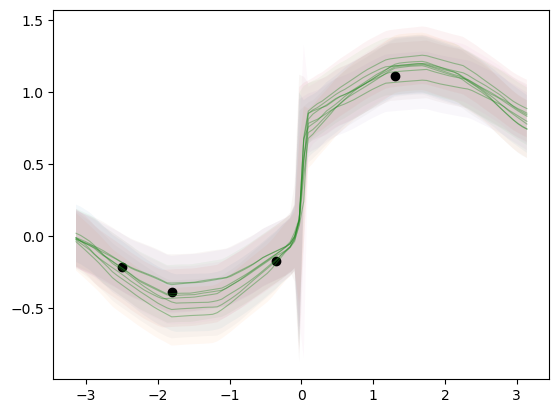

In [149]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader2:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess2.training = False

# showing 8
for i in range(8):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess2(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

/var/folders/mq/9lm4wx5x1dg5n49x3vw8bsqc0000gn/T/ipykernel_68920/2330620319.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix = torch.tensor(y.squeeze(dim = 0))


torch.Size([100, 1])


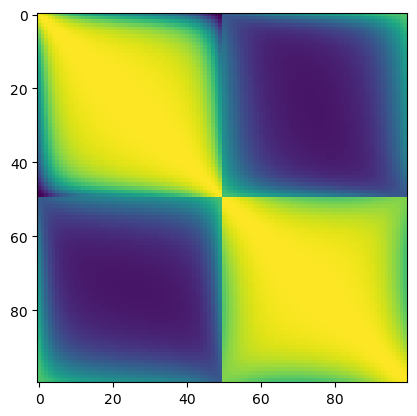

In [75]:
batch_size = 1

data_loader_covar = DataLoader(dataset2, batch_size = batch_size, shuffle = True)
matrix = torch.tensor(0)

for i, data in enumerate(data_loader_covar):
    x, y = data
    if(i == 0):
        matrix = torch.tensor(y.squeeze(dim = 0))
        print(matrix.shape)
    else:
        matrix = torch.cat((matrix, y.squeeze(dim = 0)), dim = 1)

matrix.shape

torch.corrcoef(matrix)
plt.imshow(torch.corrcoef(matrix))


In [ ]:
for batch in data_loader2:
    break

# Use batch to create random set of context points
x, y = batch
x.shape
